![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.stats as stats

from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn           as sns

In [2]:
sns.set_style('darkgrid')

# Loading and defining functions

In [3]:
df0 = pd.read_csv('rental_info.csv')

# EDA 1 - Raw data

## Dataset sizze

In [4]:
df0.shape

(15861, 15)

## Data types

In [5]:
df0.dtypes

rental_date          object
return_date          object
amount              float64
release_year        float64
rental_rate         float64
length              float64
replacement_cost    float64
special_features     object
NC-17                 int64
PG                    int64
PG-13                 int64
R                     int64
amount_2            float64
length_2            float64
rental_rate_2       float64
dtype: object

## Null values

In [6]:
df0.isnull().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

## Numerical columns description

In [7]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,15861.0,4.217161,2.360383,0.9900,2.9900,3.9900,4.9900,11.9900
release_year,15861.0,2006.885379,2.025027,2004.0000,2005.0000,2007.0000,2009.0000,2010.0000
rental_rate,15861.0,2.944101,1.649766,0.9900,0.9900,2.9900,4.9900,4.9900
length,15861.0,114.994578,40.114715,46.0000,81.0000,114.0000,148.0000,185.0000
replacement_cost,15861.0,20.224727,6.083784,9.9900,14.9900,20.9900,25.9900,29.9900
NC-17,15861.0,0.204842,0.403599,0.0000,0.0000,0.0000,0.0000,1.0000
PG,15861.0,0.200303,0.400239,0.0000,0.0000,0.0000,0.0000,1.0000
PG-13,15861.0,0.223378,0.416523,0.0000,0.0000,0.0000,0.0000,1.0000
R,15861.0,0.198726,0.399054,0.0000,0.0000,0.0000,0.0000,1.0000
amount_2,15861.0,23.355504,23.503164,0.9801,8.9401,15.9201,24.9001,143.7601


## Categorical columns description

In [8]:
df0.describe(exclude='number').T

,count,unique,top,freq
rental_date,15861,15813,2005-06-20 14:10:29+00:00,2
return_date,15861,15836,2005-08-29 00:49:42+00:00,2
special_features,15861,15,"{Trailers,Commentaries,""Behind the Scenes""}",1308


# Pre processing

In [9]:
df0.head(3)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [10]:
df = df0.copy()

df = df.assign(
               rental_date = lambda x:
                                pd.to_datetime(x['rental_date'], format="%Y-%m-%d %H:%M:%S"),
               return_date = lambda x:
                                pd.to_datetime(x['return_date'], format="%Y-%m-%d %H:%M:%S"),
               rental_length_days = (lambda x:
                                (x['return_date'] - x['rental_date']).dt.days),
               deleted_scenes = lambda x: 
                                [1 if 'Deleted Scenes' in feature else 0 for feature in x['special_features']],
               behind_the_scenes = lambda x: 
                                [1 if 'Behind the Scenes' in feature else 0 for feature in x['special_features']]
              )

df = df.drop(columns=['rental_date', 'return_date', 'special_features'])

# EDA 2 - Pre processed data

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,15861.0,4.217161,2.360383,0.9900,2.9900,3.9900,4.9900,11.9900
release_year,15861.0,2006.885379,2.025027,2004.0000,2005.0000,2007.0000,2009.0000,2010.0000
rental_rate,15861.0,2.944101,1.649766,0.9900,0.9900,2.9900,4.9900,4.9900
length,15861.0,114.994578,40.114715,46.0000,81.0000,114.0000,148.0000,185.0000
replacement_cost,15861.0,20.224727,6.083784,9.9900,14.9900,20.9900,25.9900,29.9900
NC-17,15861.0,0.204842,0.403599,0.0000,0.0000,0.0000,0.0000,1.0000
PG,15861.0,0.200303,0.400239,0.0000,0.0000,0.0000,0.0000,1.0000
PG-13,15861.0,0.223378,0.416523,0.0000,0.0000,0.0000,0.0000,1.0000
R,15861.0,0.198726,0.399054,0.0000,0.0000,0.0000,0.0000,1.0000
amount_2,15861.0,23.355504,23.503164,0.9801,8.9401,15.9201,24.9001,143.7601


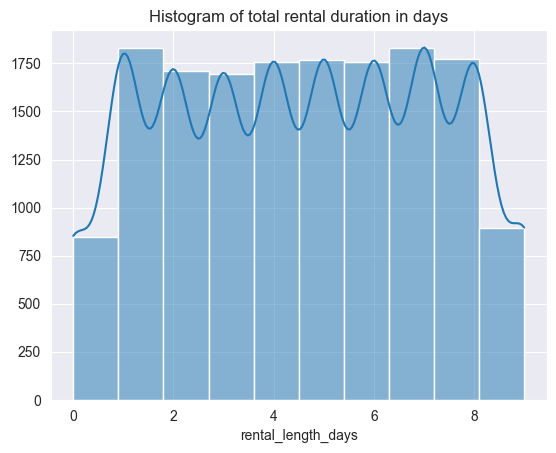

In [12]:
sns.histplot(df['rental_length_days'], kde=True, bins=10);
plt.ylabel('');
plt.title('Histogram of total rental duration in days');

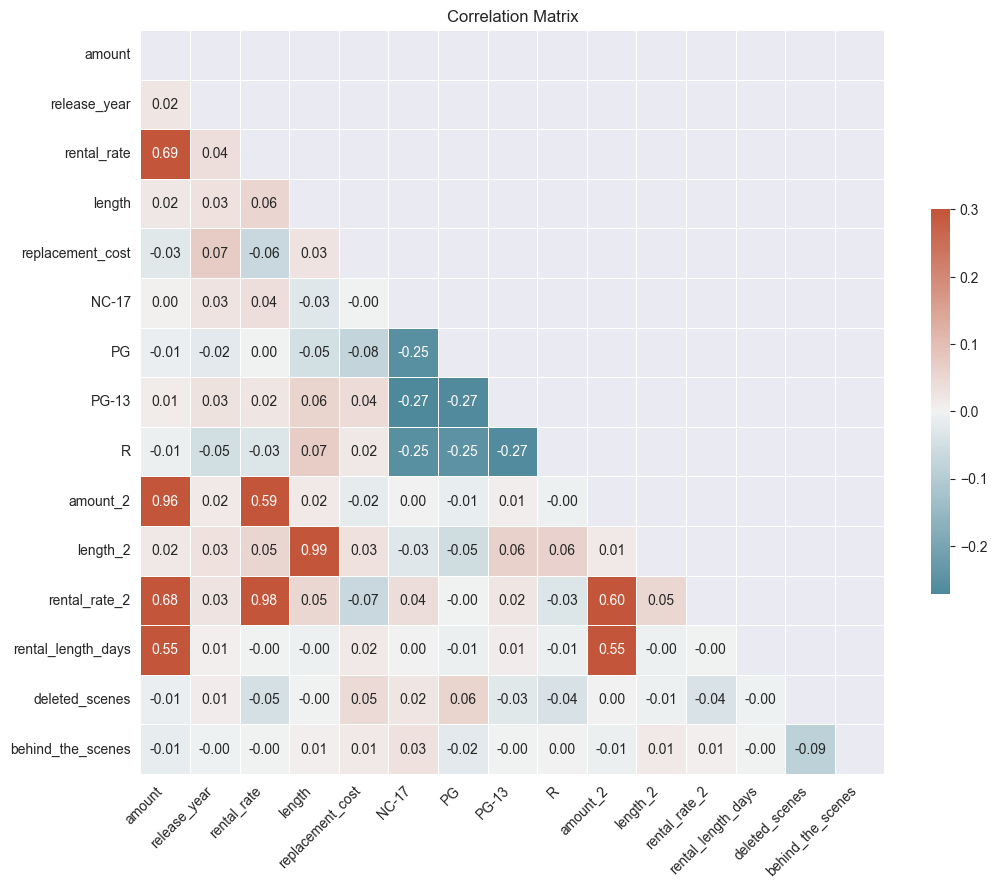

In [13]:
corr_matrix = df.corr()

# Create a mask for the upper triangle (top diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a custom color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Customize the plot
plt.title('Correlation Matrix');
plt.xticks(rotation=45, ha="right");

# Model performances before feature engineering

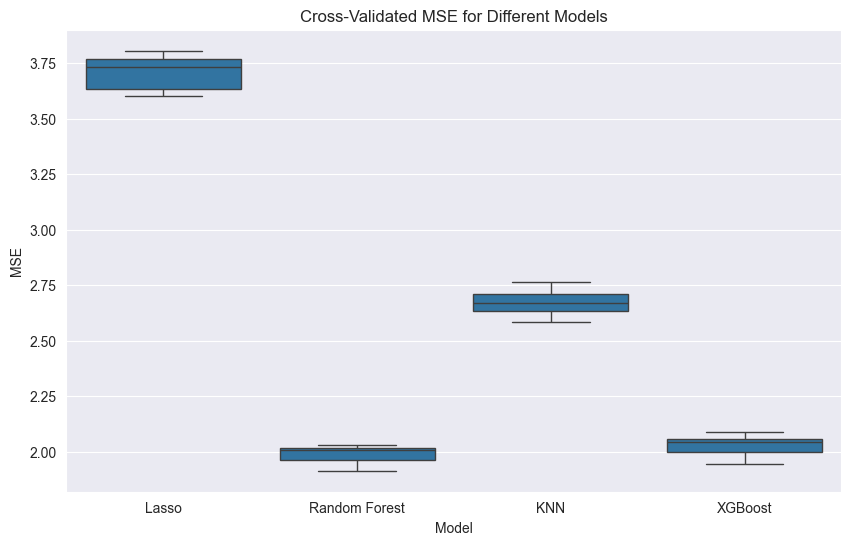

In [14]:
X = df.drop(columns=['rental_length_days'])
y = df.loc[:,'rental_length_days']

mdl_lasso = Lasso(alpha=1.0)
mdl_rf = RandomForestRegressor(n_estimators=100, random_state=9)
mdl_knn = KNeighborsRegressor(n_neighbors=5)
mdl_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)

models = [mdl_lasso, mdl_rf, mdl_knn, mdl_xgb]
model_names = ['Lasso', 'Random Forest', 'KNN', 'XGBoost']

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=9)

# Perform cross-validation for each model
mse_results = pd.DataFrame()
aux = pd.DataFrame()
for model, name in zip(models, model_names):
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    aux = pd.DataFrame({'Model': name, 'MSE': mse_scores})
    mse_results = pd.concat([mse_results, aux], axis=0)
    
# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='MSE', data=mse_results)
plt.title('Cross-Validated MSE for Different Models');

In [15]:
mse_results = (mse_results
                .groupby('Model')
                ['MSE']
                .agg(['mean','std'])
                .round(2)
              )

In [16]:
display(mse_results)

,mean,std
Model,,
KNN,2.67,0.07
Lasso,3.71,0.09
Random Forest,1.99,0.05
XGBoost,2.03,0.06


# Feature Engineering

In [17]:
df1 = df.copy()

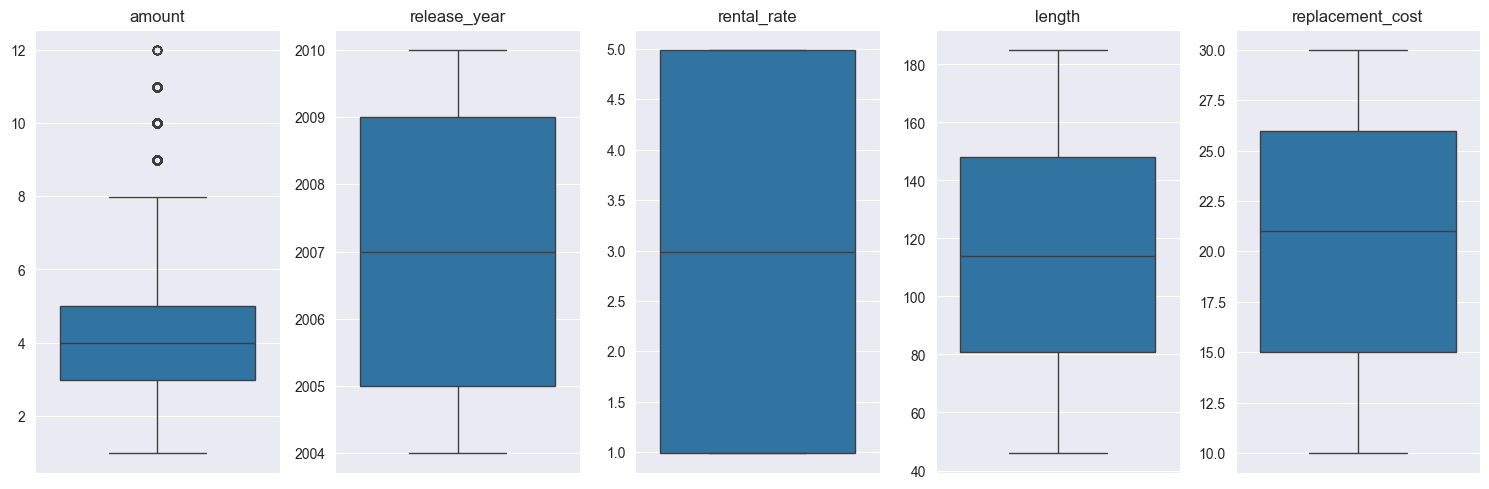

In [18]:
aux = df1[['amount', 'release_year', 'rental_rate', 'length', 'replacement_cost']]

fig, axes = plt.subplots(nrows=1, ncols=len(aux.columns), figsize=(15, 5))
# Create boxplots for each variable
for i, col in enumerate(aux.columns):
    sns.boxplot(y=df1[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')
    
plt.tight_layout()

**For these numerical columns, standardization will be aplied individually to improve model performance.**

In [19]:
# Initialize the StandardScaler
scaler = StandardScaler()

columns_to_standardize = ['amount', 'amount_2', 'release_year', 'rental_rate_2', 'length', 'length_2', 'replacement_cost']

# Fit and transform the selected columns
df1[columns_to_standardize] = scaler.fit_transform(df1[columns_to_standardize])

**Now we run random forest model with scaled variables and perform feature selection**

              Feature  Importance
0              amount    3.395792
2         rental_rate    1.185868
9            amount_2    0.640336
8                   R    0.089618
12     deleted_scenes    0.084688
5               NC-17    0.071706
3              length    0.034297
13  behind_the_scenes    0.033750
1        release_year    0.014594
7               PG-13    0.011177
4    replacement_cost    0.000000
6                  PG    0.000000
10           length_2    0.000000
11      rental_rate_2    0.000000


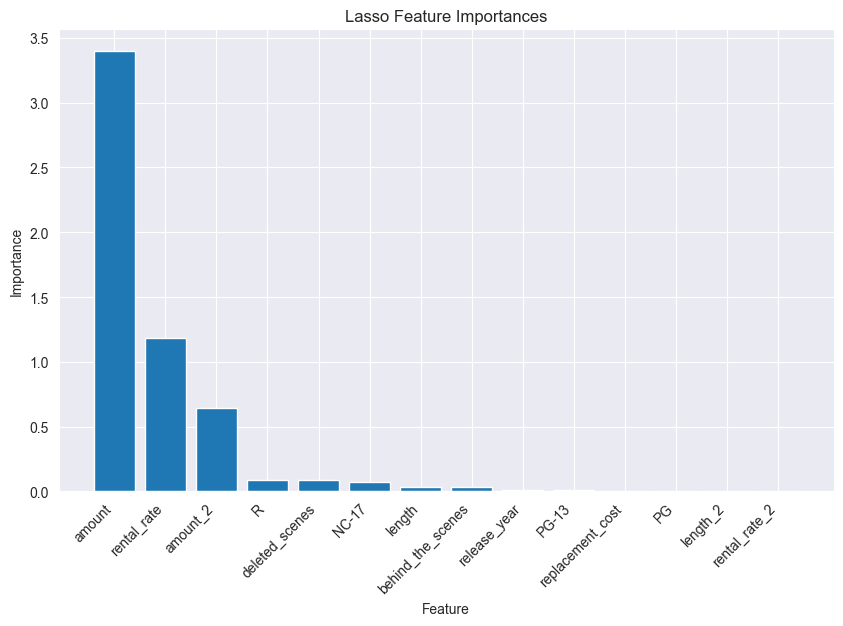

In [20]:
## LASSO
# Separate features (X) and target variable (y)
X = df1.drop(columns=['rental_length_days'])
y = df1.loc[:, 'rental_length_days']

# Initialize Lasso Regressor
alpha = 0.01  # You can adjust the regularization strength
mdl_lasso = Lasso(alpha=alpha, random_state=9)

# Fit the model
mdl_lasso.fit(X, y)

# Get feature importances (absolute values of coefficients)
feature_importances = abs(mdl_lasso.coef_)

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Lasso Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
df1 = df1.drop(columns=['amount_2', 'rental_rate_2', 'length_2', 'PG'])

**In this case, the decision was to remove 'PG' variable to elminate the risk of causing multicolinearity, since we already have four dummy variables for the rating. Keeping all of them would result in perfect multicollinearity because the dummy variables sum up to a constant (e.g., 1 + 0 = 1). This perfect correlation among the dummy variables can lead to numerical instability in model estimation.**

**Also amount_2, length_2 and rental_rate_2 variables were removed since they can influence the model with its duplicity and their counterpart showed higher feature importance**

**Now the model is trained again and metrics are observed after feature engineering**

# Model performance after feature engineering

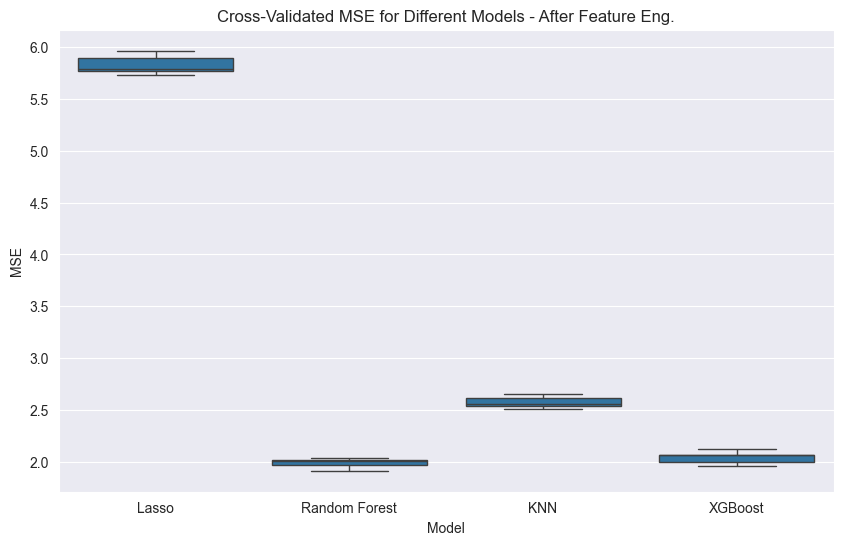

In [22]:
X_fe = df1.drop(columns=['rental_length_days'])
y = df1.loc[:,'rental_length_days']

mdl_lasso = Lasso(alpha=1.0)
mdl_rf = RandomForestRegressor(n_estimators=100, random_state=9)
mdl_knn = KNeighborsRegressor(n_neighbors=5)
mdl_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)

models = [mdl_lasso, mdl_rf, mdl_knn, mdl_xgb]
model_names = ['Lasso', 'Random Forest', 'KNN', 'XGBoost']

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=9)

# Perform cross-validation for each model after feature engineering
mse_results_fe = pd.DataFrame()
aux = pd.DataFrame()
for model, name in zip(models, model_names):
    mse_scores = -cross_val_score(model, X_fe, y, cv=kf, scoring='neg_mean_squared_error')
    aux = pd.DataFrame({'Model': name, 'MSE': mse_scores})
    mse_results_fe = pd.concat([mse_results_fe, aux], axis=0)
    
# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='MSE', data=mse_results_fe)
plt.title('Cross-Validated MSE for Different Models - After Feature Eng.');

In [23]:
mse_results_fe = (mse_results_fe
                    .groupby('Model')
                    ['MSE']
                    .agg(['mean','std'])
                    .round(2)
                 )

In [24]:
display(mse_results_fe)

,mean,std
Model,,
KNN,2.57,0.06
Lasso,5.83,0.10
Random Forest,1.99,0.05
XGBoost,2.04,0.06


## Comparing after and before feature engineering

In [25]:
pd.merge(mse_results, mse_results_fe, left_index=True, right_index=True, suffixes=('_beforeFE', 'afterFE'))

,mean_beforeFE,std_beforeFE,meanafterFE,stdafterFE
Model,,,,
KNN,2.67,0.07,2.57,0.06
Lasso,3.71,0.09,5.83,0.10
Random Forest,1.99,0.05,1.99,0.05
XGBoost,2.03,0.06,2.04,0.06


- **Surprisingly, Lasso model showed an increase of 2.12 on MSE score after feature engineering. This may be linked to correlation between the variables which were removed, causing an overfitting on the model trained before the feature engineering**

- **KNN model had an slightly better performance after feature engineering (0.1 lower MSE score)**

- **Random Forest and XGBoost model had virtually no boost on performance after the feature engineering**


- **The recommended model for this case is Random Forest, achieving a MSE result of 1.99 with a std deviation of 0.05**
- **However, hyper-parameter tuning is still needed to achieve best possible results.**

# Writing result output

In [26]:
# Initializing best model
best_model = RandomForestRegressor(n_estimators=100, random_state=9)

# Perform train-test split
X_fe = df1.drop(columns=['rental_length_days'])
y = df1.loc[:, 'rental_length_days']
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=9)

# Training model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculating MSE metric
best_mse = mean_squared_error(y_test, y_pred)

In [27]:
best_mse

2.0321890200117134